# 📊 Desafío Bunker DB - Data Scientist

**Autor:** Nicolas Caricati
**Objetivo:** Análisis exploratorio y modelado predictivo para estimar 'likes' en publicaciones de Facebook.

---

## 1. Configuración e Importación

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge

!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from xgboost import XGBRegressor

from pyparsing import col


# Configuración visual
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Cargar datos
path = 'Facebook Metrics of Cosmetic Brand.csv'
try:
    df = pd.read_csv(path, sep=',',index_col=0)
    print("Dataset cargado correctamente.")

except FileNotFoundError:
    print(f"No se encuentra '{path}'. Asegúrate de subir el archivo de Kaggle.")

Dataset cargado correctamente.


## 2. Análisis Exploratorio (EDA)

In [ ]:
# Información general
print(f"Dimensiones: {df.shape}")
df.info()

Dimensiones: (500, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-null    int64  
 5   Post Hour                                                            500 non-null    int64  
 6   Paid                                                                 499 non-null    flo

In [ ]:
# --- Exploración de NAs ---
# Conteo total de valores nulos por columna
na_counts = df.isna().sum()

print("📊 Valores nulos por columna:")
print(na_counts[na_counts > 0])  # solo columnas con NAs

# Porcentaje de NAs respecto al total
na_percent = (df.isna().sum() / len(df)) * 100
print("\n📉 Porcentaje de NAs por columna:")
print(na_percent[na_percent > 0].round(2))

📊 Valores nulos por columna:
Paid     1
like     1
share    4
dtype: int64

📉 Porcentaje de NAs por columna:
Paid     0.2
like     0.2
share    0.8
dtype: float64


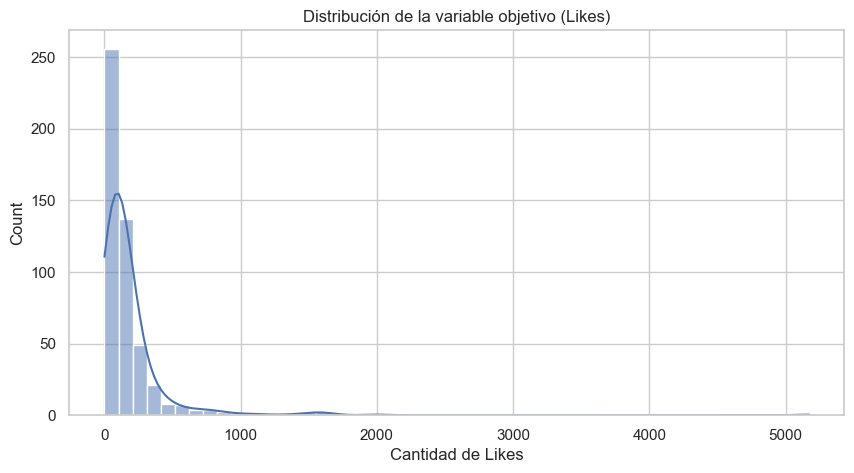

Estadísticas de Likes:
count     499.00
mean      177.95
std       323.40
min         0.00
25%        56.50
50%       101.00
75%       187.50
max      5172.00
Name: like, dtype: float64


In [ ]:
# 2. Análisis del Target (Likes)
plt.figure(figsize=(10, 5))
sns.histplot(df['like'], bins=50, kde=True)
plt.title('Distribución de la variable objetivo (Likes)')
plt.xlabel('Cantidad de Likes')
plt.show()

print("Estadísticas de Likes:")
print(df['like'].describe().round(2))

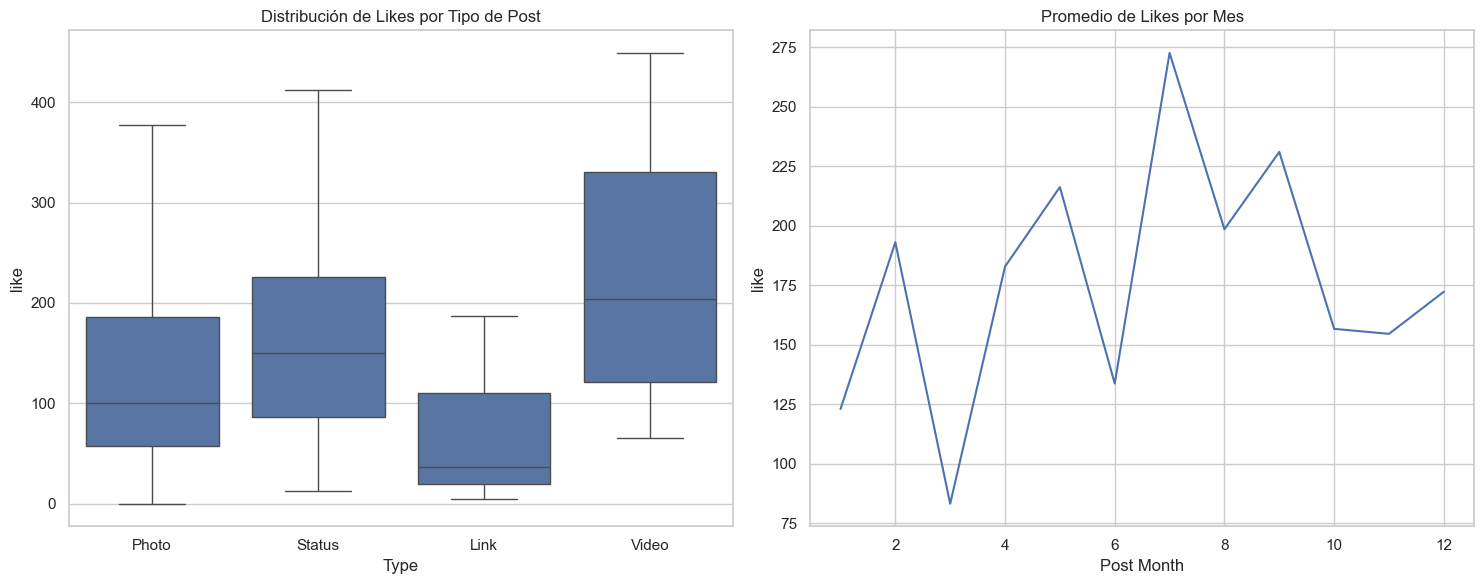

In [ ]:
# 3. Relación Variables Categóricas vs Likes
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tipo de Post
sns.boxplot(x='Type', y='like', data=df, ax=axes[0], showfliers=False)
axes[0].set_title('Distribución de Likes por Tipo de Post')

# Mes de publicación
sns.lineplot(x='Post Month', y='like', data=df, ax=axes[1], estimator='mean', errorbar=None)
axes[1].set_title('Promedio de Likes por Mes')

plt.tight_layout()
plt.show()

📊 Matriz de correlaciones (valores):
                                                    Page total likes  \
Page total likes                                                1.00   
Category                                                       -0.09   
Post Month                                                      0.94   
Post Weekday                                                   -0.01   
Post Hour                                                      -0.14   
Paid                                                            0.01   
Lifetime Post Total Reach                                      -0.08   
Lifetime Post Total Impressions                                -0.10   
Lifetime Engaged Users                                         -0.11   
Lifetime Post Consumers                                        -0.15   
Lifetime Post Consumptions                                     -0.13   
Lifetime Post Impressions by people who have li...             -0.10   
Lifetime Post reach by peop

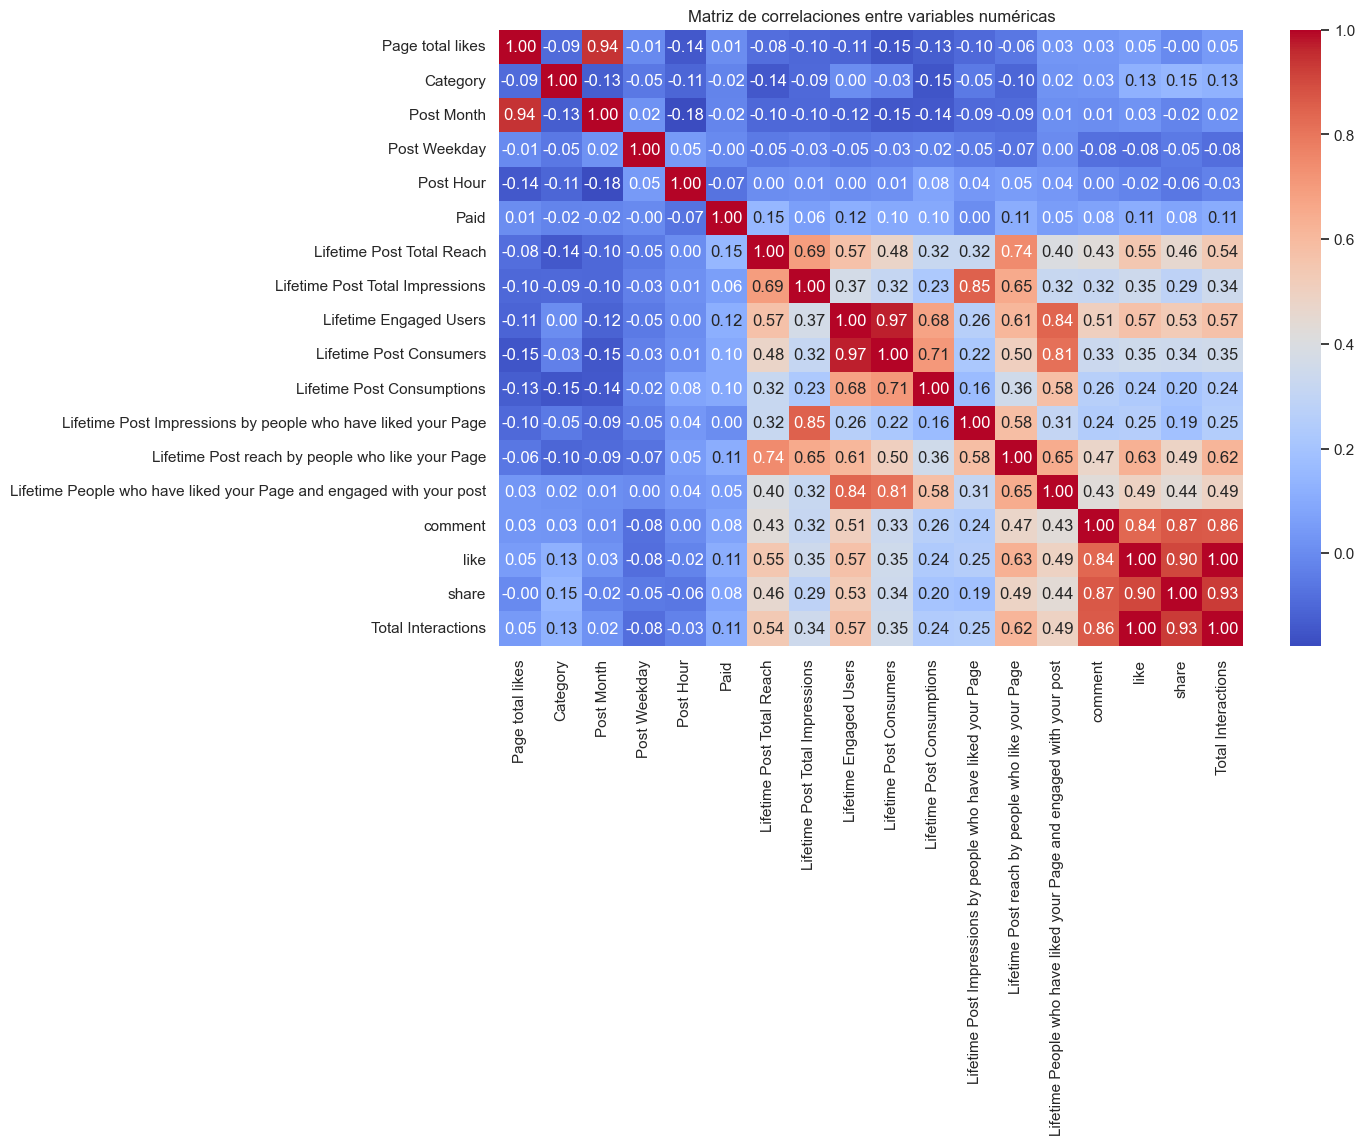

In [ ]:
# --- Matriz de correlaciones ---
corr_matrix = df.corr(numeric_only=True)  # solo columnas numéricas

print("📊 Matriz de correlaciones (valores):")
print(corr_matrix.round(2))

# --- Heatmap ---
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlaciones entre variables numéricas")
plt.show()


## 3. Preprocess

### Nulos

##### NA en Target

In [ ]:
# No nos sirven registros sin target
target_na = df['like'].isna().sum()
print(f"\n🎯 Registros con 'like' nulo: {target_na}")
df_clean = df.dropna(subset=['like']).copy()

# chequeo rápido
print(df_clean.isna().sum())



🎯 Registros con 'like' nulo: 1
Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach

##### NA en Paid

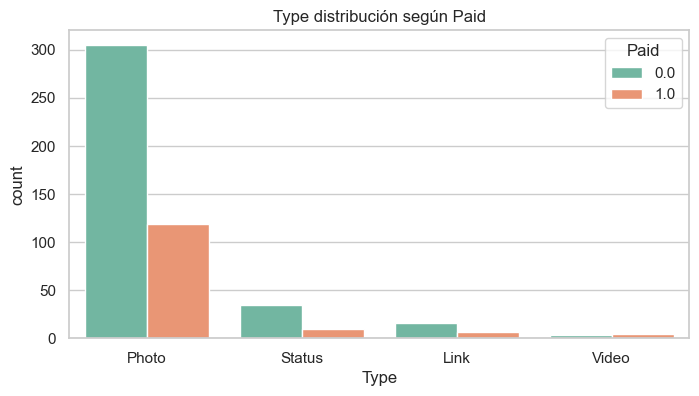

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [ ]:
# --- Análisis de registros nulos en features nulos ---

# Nulo en 'Paid'

num_cols = df_clean.select_dtypes(include=['int64','float64']).columns

# for col in num_cols:
#     plt.figure(figsize=(8,4))
#     sns.boxplot(x='Paid', y=col, data=df_clean, palette='Set2')
#     sns.stripplot(x='Paid', y=col, data=df_clean[df_clean['Paid'].isna()],
#                   color='red', marker='x', size=8, label='NA')
#     plt.title(f"{col} vs Paid (0/1/NA)")
#     plt.legend()
#     plt.show()

# # Variables categóricas
# cat_cols = df_clean.select_dtypes(include=['object']).columns

# for col in cat_cols:
#     plt.figure(figsize=(8,4))
#     sns.countplot(x=col, hue='Paid', data=df_clean, palette='Set2')
#     plt.title(f"{col} distribución según Paid")
#     plt.show()



plt.figure(figsize=(8,4))
sns.countplot(x='Type', hue='Paid', data=df_clean, palette='Set2')
plt.title(f"Type distribución según Paid")
plt.show()

# Dado que su type es "Photo", podemos inferir que es un post no pago

df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'] = df_clean.loc[df_clean['Type'] == 'Photo', 'Paid'].fillna(0)

print(df_clean.isna().sum())



##### NAs en share

In [ ]:
# Chequeo de q para todos los registros sin NA se cumple que Total Interactions = comment + like + share

df_no_na = df_clean.dropna(subset=["Total Interactions", "comment", "like", "share"]).copy()

df_no_na["check_interactions"] = (
    df_no_na["Total Interactions"] == df_no_na["comment"] + df_no_na["like"] + df_no_na["share"]
)


# Verificamos si todos cumplen
all_good = df_no_na["check_interactions"].all()

print("¿Todos los registros cumplen la condición?", all_good)


¿Todos los registros cumplen la condición? True


In [ ]:
# Imputo share

# Imputar valores faltantes en 'share' usando la relación validada
df_clean.loc[df_clean["share"].isna(), "share"] = (
    df_clean["Total Interactions"] - df_clean["comment"] - df_clean["like"]
)

# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean["share"].isna().sum())


0


In [ ]:
# Chequeo rápido: ya no debería haber NAs en 'share'
print(df_clean.isna().sum())

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   0
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

### Feature Engineering

In [ ]:
# --- Pipeline de Preprocesamiento
# 1. Definir X e y
y = df_clean['like']
X = df_clean.drop(columns=['like'])

# 2. Función para crear PostHourBin
def bin_post_hour(X):
    X = X.copy()
    bins = [0, 6, 12, 18, 24]
    labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    X['PostHourBin'] = pd.cut(X['Post Hour'], bins=bins, labels=labels, right=False)
    return X

binning_transformer = FunctionTransformer(bin_post_hour, validate=False)

# 3. Definir columnas
numeric_as_category = ['Category','Post Month']
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col not in numeric_as_category]
categorical_features = list(X.select_dtypes(include=['object']).columns) + numeric_as_category

# 4. Transformadores
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

weekday_hour_interactions = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# 5. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, [c for c in categorical_features if c not in ['Post Weekday','PostHourBin']])
        # ('weekday_hour', weekday_hour_interactions, ['Post Weekday','PostHourBin'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


# Aplicar binning + preprocessor directamente
X_preprocessed = Pipeline(steps=[
    ('binning', binning_transformer),
    ('preprocessor', preprocessor)
]).fit_transform(X)

# Convertir a DataFrame con nombres de columnas
feature_names = preprocessor.get_feature_names_out()
X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

print(X_preprocessed.shape)
print(X_preprocessed.head())


(499, 34)
   Page total likes  Post Weekday  Post Hour      Paid  \
0          1.000767     -0.072101  -1.107837 -0.621378   
1          1.000767     -0.564952   0.494513 -0.621378   
2          1.000767     -0.564952  -1.107837 -0.621378   
3          1.000767     -1.057804   0.494513  1.609325   
4          1.000767     -1.057804  -1.107837 -0.621378   

   Lifetime Post Total Reach  Lifetime Post Total Impressions  \
0                  -0.491635                        -0.319688   
1                  -0.152579                        -0.137823   
2                  -0.506547                        -0.329038   
3                   1.592317                         0.759832   
4                  -0.294043                        -0.208962   

   Lifetime Engaged Users  Lifetime Post Consumers  \
0               -0.756044                -0.783923   
1                0.543461                 0.635828   
2               -0.757060                -0.779387   
3                1.309549         

## 4. Models

## Seccion 2.1: RF Incluyendo todos los features

In [ ]:
# 1. Selección de Features

features_to_drop = ['Total Interactions']
X = X_preprocessed.drop(columns=features_to_drop)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 33), Test shape: (100, 33)


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__bootstrap', True), ('regressor__max_depth', 15), ('regressor__max_features', 0.9135614063895876), ('regressor__max_samples', 0.8921368112200251), ('regressor__min_samples_leaf', 3), ('regressor__min_samples_split', 2), ('regressor__n_estimators', 130)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 79.58
RMSE (Raíz Error Cuadrático): 209.33
R2 Score: 0.2345


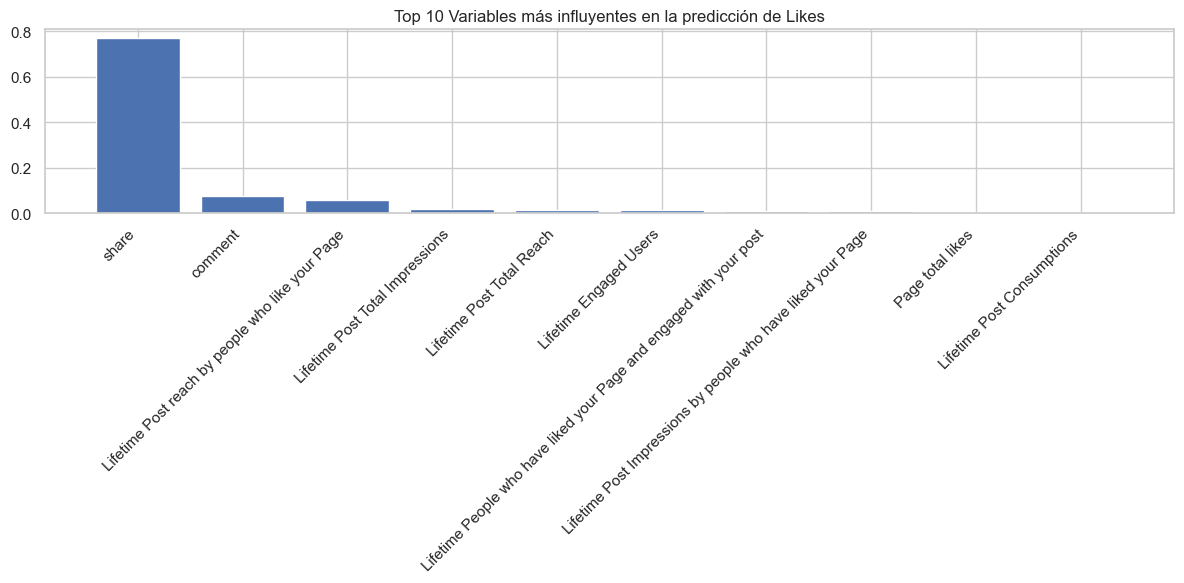

In [ ]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 2.1: RF Incluyendo todos los features (casos no virales)

In [ ]:
# Filtrar directamente en el DataFrame original
mask = df_clean['like'] < 1000   # solo publicaciones no virales
X_nonviral = X_preprocessed.loc[mask]   # filtra las filas en el DataFrame ya preprocesado
y_nonviral = df_clean.loc[mask, 'like'] # target correspondiente

# Opcional: drop de features
features_to_drop = ['Total Interactions']
X_nonviral = X_nonviral.drop(columns=features_to_drop)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_nonviral, y_nonviral, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (391, 33), Test shape: (98, 33)


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__bootstrap', True), ('regressor__max_depth', 11), ('regressor__max_features', 0.5812848950263698), ('regressor__max_samples', 1.0), ('regressor__min_samples_leaf', 2), ('regressor__min_samples_split', 3), ('regressor__n_estimators', 150)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 38.79
RMSE (Raíz Error Cuadrático): 59.40
R2 Score: 0.8019


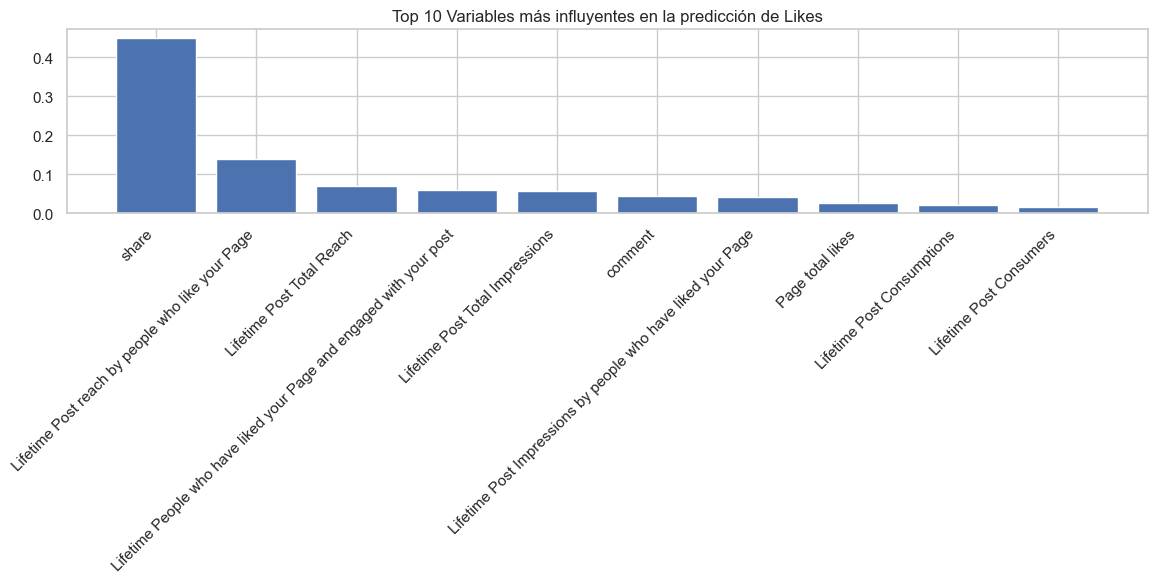

In [ ]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 2.1: RF Incluyendo todos los features (casos no virales en train, pero si en test)

In [ ]:
# Split primero SIN filtrar
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, df_clean['like'], test_size=0.2, random_state=42
)

# Filtrar solo en train
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train].copy()

# Opcional: drop de features
features_to_drop = ['Total Interactions']
X_train = X_train.drop(columns=features_to_drop, errors='ignore')
X_test = X_test.drop(columns=features_to_drop, errors='ignore')

# --- Logs de trazabilidad ---
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en train: {(~mask_train).sum()}")
print(f"Casos virales presentes en test: {(y_test >= 1000).sum()}")
print(f"Casos no virales en test: {(y_test < 1000).sum()}")


Train shape: (392, 33), Test shape: (100, 33)
Casos virales excluidos en train: 7
Casos virales presentes en test: 3
Casos no virales en test: 97


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline con el modelo
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__bootstrap', True), ('regressor__max_depth', 14), ('regressor__max_features', 1.0), ('regressor__max_samples', 1.0), ('regressor__min_samples_leaf', 2), ('regressor__min_samples_split', 2), ('regressor__n_estimators', 20)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 63.95
RMSE (Raíz Error Cuadrático): 152.92
R2 Score: 0.5915


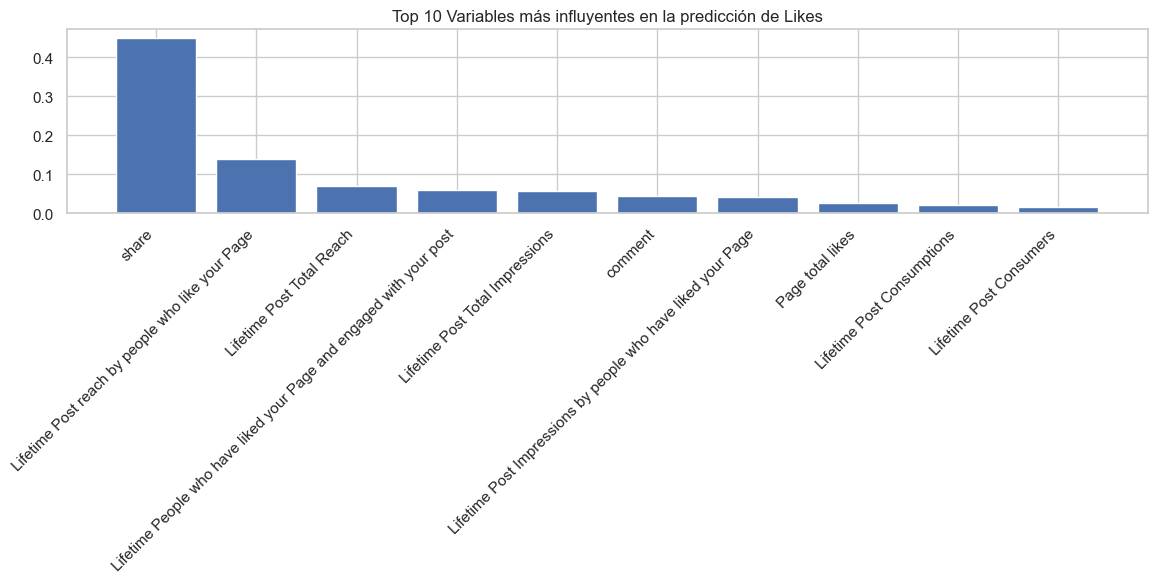

In [ ]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 2.3: KNN Solo con shares y comments

In [ ]:
# 1. Selección de Features

features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 2), Test shape: (100, 2)


In [ ]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),          # número de vecinos
    'regressor__weights': Categorical(['distance']),  # ponderación
    'regressor__p': Integer(1, 2)                      # métrica: 1=Manhattan, 2=Euclídea
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(1), np.str_('distance')] before, using random point [np.int64(26), np.int64(1), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(1), np.str_('distance')] before, using random point [np.int64(24), np.int64(1), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.int64(1), np.str_('distance')] before,

Mejores hiperparámetros KNN: OrderedDict([('regressor__n_neighbors', 4), ('regressor__p', 1), ('regressor__weights', 'distance')])


In [ ]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 74.54
RMSE (Raíz Error Cuadrático): 170.98
R2 Score: 0.4893


## Seccion 2.3: KNN Solo con shares y comments pero sacando casos virales

In [ ]:
# --- Selección de Features ---
features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]

# --- Filtro no viral en el target ---
mask = df_clean['like'] < 1000   # solo publicaciones no virales
X = X.loc[mask].copy()
y = df_clean.loc[mask, 'like']

# --- Split 80-20 ---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (391, 2), Test shape: (98, 2)


In [ ]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),          # número de vecinos
    'regressor__weights': Categorical(['distance']),  # ponderación
    'regressor__p': Integer(1, 2)                      # métrica: 1=Manhattan, 2=Euclídea
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), np.int64(2), np.str_('distance')] before, using random point [np.int64(7), np.int64(1), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), np.int64(2), np.str_('distance')] before, using random point [np.int64(26), np.int64(2), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(25), np.int64(2), np.str_('distance')] befor

Mejores hiperparámetros KNN: OrderedDict([('regressor__n_neighbors', 25), ('regressor__p', 2), ('regressor__weights', 'distance')])


In [ ]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 55.42
RMSE (Raíz Error Cuadrático): 89.81
R2 Score: 0.5472


## Seccion 2.3: KNN Solo con shares y comments pero sacando casos virales solo en train

In [ ]:
# --- Selección de Features ---
features_to_keep = ['share','comment']
X = X_preprocessed[features_to_keep]
y = df_clean['like']

# --- Split 80-20 (sin filtrar todavía) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Filtro solo en TRAIN ---
mask_train = y_train < 1000
X_train = X_train.loc[mask_train].copy()
y_train = y_train.loc[mask_train]

print(f"Train shape (filtrado): {X_train.shape}, Test shape (sin filtrar): {X_test.shape}")


Train shape (filtrado): (392, 2), Test shape (sin filtrar): (100, 2)


In [ ]:
# KNN

pipe_knn = Pipeline(steps=[
    ('regressor', KNeighborsRegressor())
])


# 4. Optimización Bayesiana para KNN
# Espacio de hiperparámetros para KNN
param_space_knn = {
    'regressor__n_neighbors': Integer(2, 30),          # número de vecinos
    'regressor__weights': Categorical(['distance']),  # ponderación
    'regressor__p': Integer(1, 2)                      # métrica: 1=Manhattan, 2=Euclídea
}

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Optimización bayesiana
opt_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_space_knn,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Entrenamos la optimización
opt_knn.fit(X_train, y_train)

print("Mejores hiperparámetros KNN:", opt_knn.best_params_)


C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(14), np.int64(2), np.str_('distance')] before, using random point [np.int64(20), np.int64(1), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(14), np.int64(2), np.str_('distance')] before, using random point [np.int64(20), np.int64(2), 'distance']
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(2), np.str_('distance')] befo

Mejores hiperparámetros KNN: OrderedDict([('regressor__n_neighbors', 13), ('regressor__p', 1), ('regressor__weights', 'distance')])


In [ ]:
# Mejor modelo optimizado
best_knn = opt_knn.best_estimator_

# Predicciones
y_pred_knn = best_knn.predict(X_test)

# Métricas
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"--- Resultados del Mejor KNN Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_knn:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_knn:.2f}")
print(f"R2 Score: {r2_knn:.4f}")


--- Resultados del Mejor KNN Optimizado ---
MAE (Error Absoluto Medio): 77.63
RMSE (Raíz Error Cuadrático): 186.71
R2 Score: 0.3910


## Seccion 3.2: Modelo Excluyendo features con data leakege

## Seccion 3.1: Linear Regression Excluyendo features con data leakege

In [ ]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [ ]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 10, prior='log-uniform')  # fuerza de regularización
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # en regresión lineal suele ser más interpretativo
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__alpha', 10.0)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 144.17
RMSE (Raíz Error Cuadrático): 241.49
R2 Score: -0.0188


In [ ]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']  # Ridge / LinearRegression / Lasso

coef = lr.coef_
intercept = lr.intercept_

# Usar directamente las columnas de X_preprocessed
feature_names = X_train.columns  # si hiciste split sobre X_preprocessed

import pandas as pd
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))  # top 20 más influyentes


             feature  coefficient
17      Post Month_7    79.001624
16      Post Month_6   -77.701264
8         Category_1   -54.626645
15      Post Month_5    36.476534
3               Paid    32.589302
10        Category_3    31.053276
4          Type_Link   -30.526411
12      Post Month_2    26.992706
7         Type_Video    25.388243
1       Post Weekday   -23.874071
9         Category_2    23.573368
13      Post Month_3   -21.143084
20     Post Month_10   -20.743291
0   Page total likes    20.657926
21     Post Month_11   -18.900062
5         Type_Photo    14.243031
19      Post Month_9    -9.958937
6        Type_Status    -9.104863
11      Post Month_1     5.215775
14      Post Month_4    -4.116445


## Seccion 3.1: Linear Regression Excluyendo features con data leakege (Excluyendo Virales)

In [ ]:

# 1. Selección de Features
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Excluir casos virales en todo el dataset
mask = y < 1000
X = X.loc[mask].copy()
y = y.loc[mask].copy()

# 3. Split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en todo el dataset: {(~mask).sum()}")


Train shape: (391, 23), Test shape: (98, 23)
Casos virales excluidos en todo el dataset: 10


In [ ]:
# Regresión Lineal con Ridge
pipe = Pipeline(steps=[
    ('regressor', Ridge())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Espacio de hiperparámetros
param_space = {
    'regressor__alpha': Real(1e-3, 10, prior='log-uniform')  # fuerza de regularización
}

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # en regresión lineal suele ser más interpretativo
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__alpha', 10.0)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 93.58
RMSE (Raíz Error Cuadrático): 133.42
R2 Score: 0.0007


In [ ]:
# Mejor modelo lineal
lr = best_model.named_steps['regressor']  # Ridge / LinearRegression / Lasso

coef = lr.coef_
intercept = lr.intercept_

# Usar directamente las columnas de X_preprocessed
feature_names = X_train.columns  # si hiciste split sobre X_preprocessed

import pandas as pd
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df.head(20))  # top 20 más influyentes


             feature  coefficient
4          Type_Link   -46.523468
16      Post Month_6   -35.640876
7         Type_Video    24.139020
6        Type_Status    21.912561
10        Category_3    21.605743
8         Category_1   -19.833185
18      Post Month_8    17.138179
11      Post Month_1    13.405428
17      Post Month_7    12.756638
21     Post Month_11    12.458772
3               Paid    11.145535
0   Page total likes    10.375612
2          Post Hour    -9.963099
14      Post Month_4    -8.334827
12      Post Month_2     7.627816
13      Post Month_3    -7.580889
20     Post Month_10    -6.826575
22     Post Month_12    -5.073142
15      Post Month_5     3.990864
19      Post Month_9    -3.921387


## Seccion 3.2: RF Excluyendo features con data leakege

In [ ]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline SOLO con el modelo (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__bootstrap', True), ('regressor__max_depth', 12), ('regressor__max_features', 0.3), ('regressor__max_samples', 0.7876124765891157), ('regressor__min_samples_leaf', 10), ('regressor__min_samples_split', 19), ('regressor__n_estimators', 150)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 144.38
RMSE (Raíz Error Cuadrático): 237.51
R2 Score: 0.0144


Número total de features usadas en el entrenamiento: 561
Listado de features finales:
0: num__Page total likes
1: num__Post Hour
2: num__Paid
3: cat__Type_Link
4: cat__Type_Photo
5: cat__Type_Status
6: cat__Type_Video
7: cat__Category_1
8: cat__Category_2
9: cat__Category_3
10: cat__Post Month_1
11: cat__Post Month_2
12: cat__Post Month_3
13: cat__Post Month_4
14: cat__Post Month_5
15: cat__Post Month_6
16: cat__Post Month_7
17: cat__Post Month_8
18: cat__Post Month_9
19: cat__Post Month_10
20: cat__Post Month_11
21: cat__Post Month_12
22: cat__Post Weekday_1
23: cat__Post Weekday_2
24: cat__Post Weekday_3
25: cat__Post Weekday_4
26: cat__Post Weekday_5
27: cat__Post Weekday_6
28: cat__Post Weekday_7
29: cat__PostHourBin_Madrugada
30: cat__PostHourBin_Mañana
31: cat__PostHourBin_Noche
32: cat__PostHourBin_Tarde
33: num__Page total likes num__Post Hour
34: num__Page total likes num__Paid
35: num__Page total likes cat__Type_Link
36: num__Page total likes cat__Type_Photo
37: num__Page tot

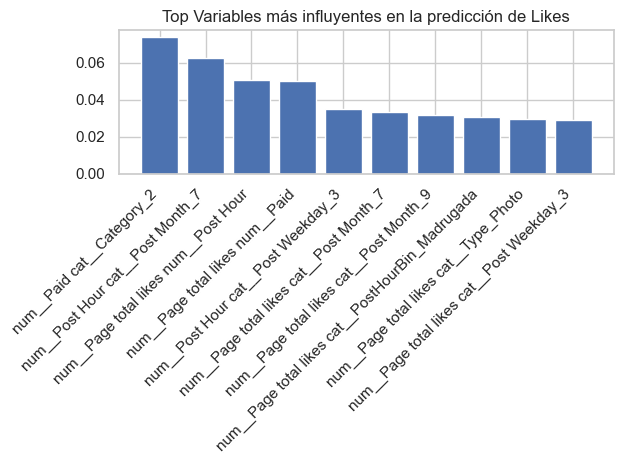

In [ ]:
# 5. Feature Importance (Interpretación)

# Paso 1: obtener nombres del preprocesamiento
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Paso 2: obtener nombres después de PolynomialFeatures
interaction = best_model.named_steps['interaction_transformer']
feature_names = interaction.get_feature_names_out(feature_names)

print(f"Número total de features usadas en el entrenamiento: {len(feature_names)}")
print("Listado de features finales:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

rf = best_model.named_steps['regressor']

# Paso 3: importancias
importances = rf.feature_importances_

# Paso 4: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 3.2: RF Excluyendo features con data leakege (no virales)

In [ ]:
# 1. Selección de Features
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment", "share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Excluir casos virales en todo el dataset
mask = y < 1000
X = X.loc[mask].copy()
y = y.loc[mask].copy()

# 3. Split 80-20 (ya filtrado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"[Sin Virales] Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en todo el dataset: {(~mask).sum()}")


[Sin Virales] Train shape: (391, 23), Test shape: (98, 23)
Casos virales excluidos en todo el dataset: 10


In [ ]:
# 3. Optimización de Hiperparámetros con Optimización Bayesiana
param_space = {
    'regressor__n_estimators': Integer(20, 150),
    'regressor__max_depth': Integer(2, 15),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(2, 10),
    'regressor__max_features': Real(0.3, 1.0, prior='uniform'),
    'regressor__bootstrap': Categorical([True]),
    'regressor__max_samples': Real(0.5, 1.0, prior='uniform')
}

# Pipeline SOLO con el modelo (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='neg_mean_squared_error'  # podés cambiar a 'r2' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__bootstrap', True), ('regressor__max_depth', 12), ('regressor__max_features', 0.7784617082852731), ('regressor__max_samples', 0.9753560982146403), ('regressor__min_samples_leaf', 7), ('regressor__min_samples_split', 9), ('regressor__n_estimators', 117)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 90.30
RMSE (Raíz Error Cuadrático): 134.23
R2 Score: -0.0115


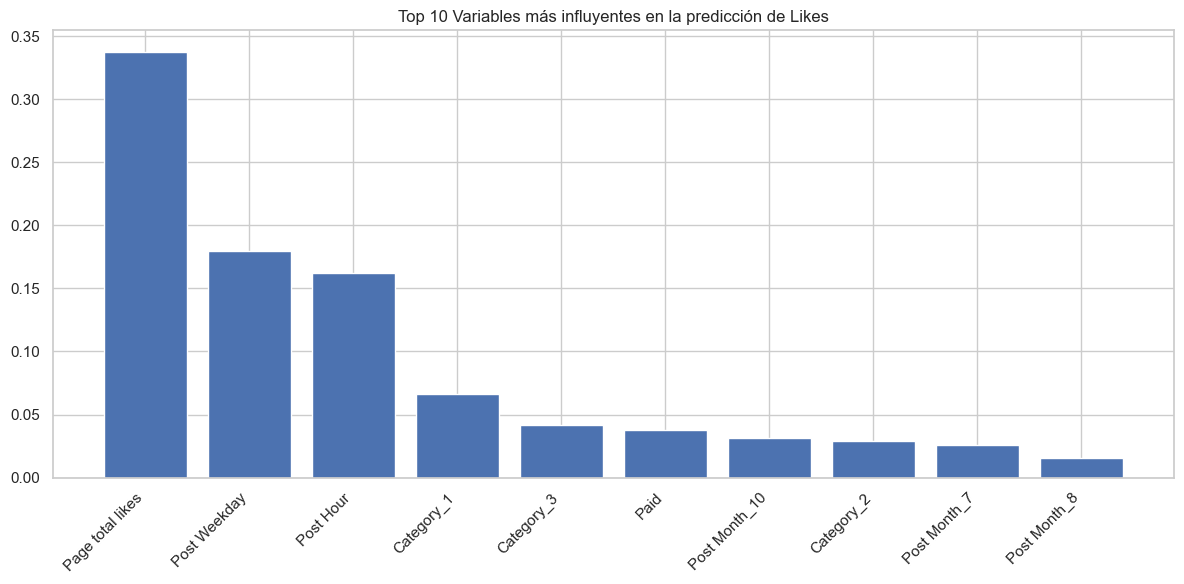

In [ ]:
# Acceder al modelo entrenado
rf_model = best_model.named_steps['regressor']  # si usaste pipeline
# Si no tenés pipeline, simplemente: rf_model = best_model

# Importancias
importances = rf_model.feature_importances_

# Nombres de features (usa X_train.columns si no tenés preprocesador)
feature_names = X_train.columns

# Ordenar de mayor a menor
indices = np.argsort(importances)[::-1]

# Graficar Top 10
plt.figure(figsize=(12, 6))
plt.title("Top 10 Variables más influyentes en la predicción de Likes")
plt.bar(range(10), importances[indices[:10]], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 3.3: XGBoost Excluyendo features con data leakege

In [ ]:
# 1. Selección de Features

leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# Split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (399, 23), Test shape: (100, 23)


In [ ]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 1000),        # número de árboles
    'regressor__max_depth': Integer(5, 500),             # profundidad máxima
    'regressor__learning_rate': Real(0.001, 0.15, prior='log-uniform'),  # tasa de aprendizaje
    'regressor__subsample': Real(0.5, 1.0),              # fracción de muestras por árbol
    'regressor__colsample_bytree': Real(0.5, 1.0),       # fracción de features por árbol
}

# Pipeline SOLO con XGBoost (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',   # regresión clásica
        random_state=42,
        n_jobs=-1,
        tree_method='hist'              # más rápido en datasets medianos
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # podés cambiar a 'neg_mean_squared_error' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__colsample_bytree', 0.5), ('regressor__learning_rate', 0.0011218054462766912), ('regressor__max_depth', 500), ('regressor__n_estimators', 623), ('regressor__subsample', 0.5)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 142.82
RMSE (Raíz Error Cuadrático): 237.44
R2 Score: 0.0151


Número total de features usadas en el entrenamiento: 561
Listado de features finales:
0: num__Page total likes
1: num__Post Hour
2: num__Paid
3: cat__Type_Link
4: cat__Type_Photo
5: cat__Type_Status
6: cat__Type_Video
7: cat__Category_1
8: cat__Category_2
9: cat__Category_3
10: cat__Post Month_1
11: cat__Post Month_2
12: cat__Post Month_3
13: cat__Post Month_4
14: cat__Post Month_5
15: cat__Post Month_6
16: cat__Post Month_7
17: cat__Post Month_8
18: cat__Post Month_9
19: cat__Post Month_10
20: cat__Post Month_11
21: cat__Post Month_12
22: cat__Post Weekday_1
23: cat__Post Weekday_2
24: cat__Post Weekday_3
25: cat__Post Weekday_4
26: cat__Post Weekday_5
27: cat__Post Weekday_6
28: cat__Post Weekday_7
29: cat__PostHourBin_Madrugada
30: cat__PostHourBin_Mañana
31: cat__PostHourBin_Noche
32: cat__PostHourBin_Tarde
33: num__Page total likes num__Post Hour
34: num__Page total likes num__Paid
35: num__Page total likes cat__Type_Link
36: num__Page total likes cat__Type_Photo
37: num__Page tot

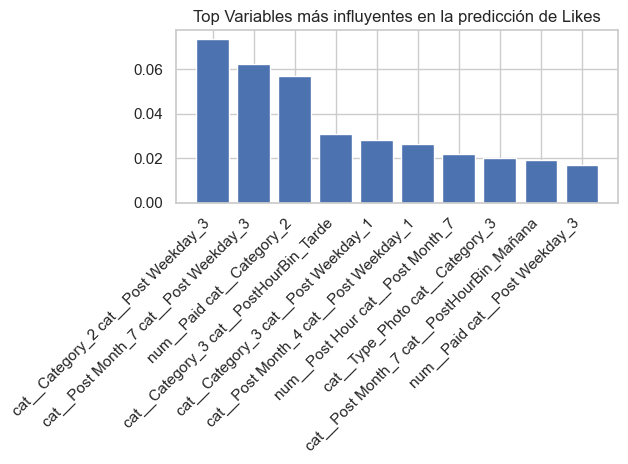

In [ ]:
# 5. Feature Importance (Interpretación)

# Paso 1: obtener nombres del preprocesamiento
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Paso 2: obtener nombres después de PolynomialFeatures
interaction = best_model.named_steps['interaction_transformer']
feature_names = interaction.get_feature_names_out(feature_names)

print(f"Número total de features usadas en el entrenamiento: {len(feature_names)}")
print("Listado de features finales:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

rf = best_model.named_steps['regressor']

# Paso 3: importancias
importances = rf.feature_importances_

# Paso 4: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Seccion 3.3: XGBoost Excluyendo features con data leakege pero sacando casos virales

In [ ]:
# 1. Selección de Features
leakage_cols = [col for col in df_clean.columns if col.startswith("Lifetime")]
leakage_cols += ["comment","share", "Total Interactions"]

X = X_preprocessed.drop(columns=leakage_cols)
y = df_clean['like']

# 2. Excluir casos virales en todo el dataset
mask = y < 1000
X = X.loc[mask].copy()
y = y.loc[mask].copy()

# 3. Split 80-20 (ya filtrado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"[Sin Virales] Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Casos virales excluidos en todo el dataset: {(~mask).sum()}")


[Sin Virales] Train shape: (391, 23), Test shape: (98, 23)
Casos virales excluidos en todo el dataset: 10


In [ ]:
# Espacio de hiperparámetros para XGBoost
param_space = {
    'regressor__n_estimators': Integer(50, 1000),        # número de árboles
    'regressor__max_depth': Integer(5, 500),             # profundidad máxima
    'regressor__learning_rate': Real(0.001, 0.15, prior='log-uniform'),  # tasa de aprendizaje
    'regressor__subsample': Real(0.5, 1.0),              # fracción de muestras por árbol
    'regressor__colsample_bytree': Real(0.5, 1.0),       # fracción de features por árbol
}

# Pipeline SOLO con XGBoost (sin binning, sin preprocessor, sin interaction_transformer)
pipe = Pipeline(steps=[
    ('regressor', XGBRegressor(
        objective='reg:squarederror',   # regresión clásica
        random_state=42,
        n_jobs=-1,
        tree_method='hist'              # más rápido en datasets medianos
    ))
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# BayesSearchCV
opt = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    scoring='r2'   # podés cambiar a 'neg_mean_squared_error' si preferís
)

# Entrenamiento
opt.fit(X_train, y_train)

# Mejor modelo y predicciones
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)

print("Mejores hiperparámetros:", opt.best_params_)


Mejores hiperparámetros: OrderedDict([('regressor__colsample_bytree', 0.5), ('regressor__learning_rate', 0.0052982380785259455), ('regressor__max_depth', 5), ('regressor__n_estimators', 265), ('regressor__subsample', 0.5)])


In [ ]:
# Predicciones sobre el conjunto de test
y_pred_opt = best_model.predict(X_test)

# Cálculo de métricas
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

# Resultados
print(f"--- Resultados del Mejor Modelo Optimizado ---")
print(f"MAE (Error Absoluto Medio): {mae_opt:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse_opt:.2f}")
print(f"R2 Score: {r2_opt:.4f}")


--- Resultados del Mejor Modelo Optimizado ---
MAE (Error Absoluto Medio): 93.32
RMSE (Raíz Error Cuadrático): 135.14
R2 Score: -0.0252


Número total de features usadas en el entrenamiento: 34
Listado de features finales:
0: Page total likes
1: Post Weekday
2: Post Hour
3: Paid
4: Lifetime Post Total Reach
5: Lifetime Post Total Impressions
6: Lifetime Engaged Users
7: Lifetime Post Consumers
8: Lifetime Post Consumptions
9: Lifetime Post Impressions by people who have liked your Page
10: Lifetime Post reach by people who like your Page
11: Lifetime People who have liked your Page and engaged with your post
12: comment
13: share
14: Total Interactions
15: Type_Link
16: Type_Photo
17: Type_Status
18: Type_Video
19: Category_1
20: Category_2
21: Category_3
22: Post Month_1
23: Post Month_2
24: Post Month_3
25: Post Month_4
26: Post Month_5
27: Post Month_6
28: Post Month_7
29: Post Month_8
30: Post Month_9
31: Post Month_10
32: Post Month_11
33: Post Month_12


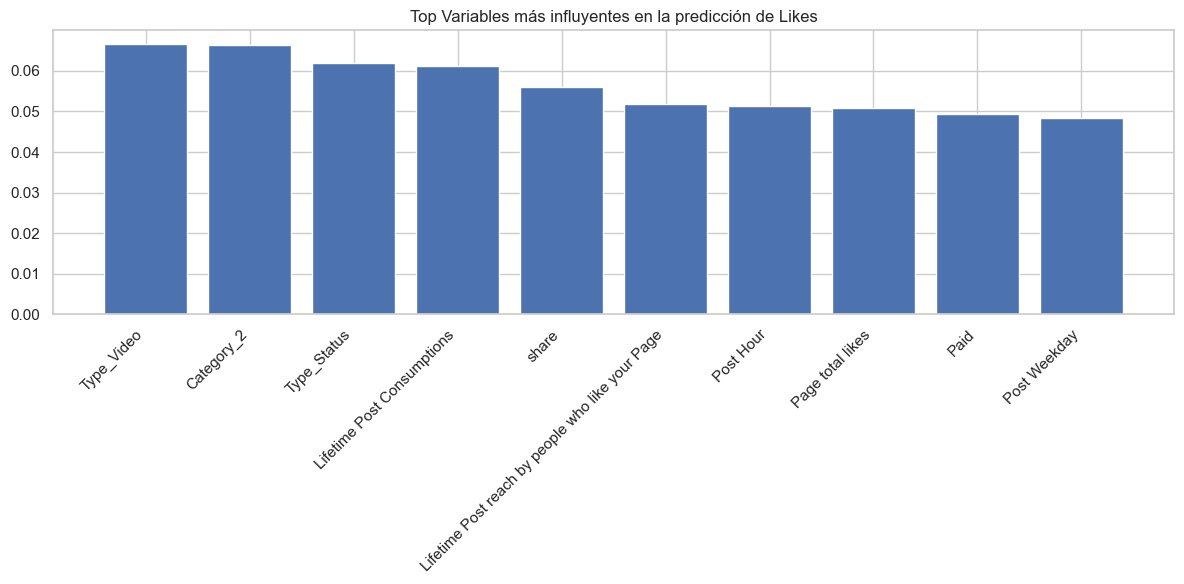

In [ ]:
# Acceder al modelo entrenado
rf = best_model.named_steps['regressor']  # si tu pipeline tiene 'regressor'
# Si no, simplemente: rf = best_model

# Paso 1: nombres de features desde X_preprocessed
feature_names = X_preprocessed.columns

print(f"Número total de features usadas en el entrenamiento: {len(feature_names)}")
print("Listado de features finales:")
for i, name in enumerate(feature_names):
    print(f"{i}: {name}")

# Paso 2: importancias
importances = rf.feature_importances_

# Paso 3: ordenar y graficar
indices = np.argsort(importances)[::-1]
top_n = min(10, len(feature_names))

plt.figure(figsize=(12, 6))
plt.title("Top Variables más influyentes en la predicción de Likes")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()
